In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q, get_factorial_cache, get_taylor_expanded_ansatz

In [2]:
plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')
device = "cpu"

In [13]:

outfile_name = f"thrust_2_3d"

save_dict = {}

with open(f"output/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)
   
losses = np.load(f"output/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

print(save_dict["configs"])

{'distribution': 'thrust', 'run_toy': False, 'order_to_match': 1, 'name': '3d', 'mstar': 1, 'init_random': True, 'init_at_answer': False, 'init_close_to_answer': False, 'learn_theta': True, 'ratio_loss': False, 'weighted_mse_loss': False, 'use_logbins': False, 'n_bins': 100, 't_min': 0, 't_max': 10, 'epochs': 30000, 'batch_size': 345, 'lr': 0.01, 'seed': 42, 'm': 3, 'n': 3, 'device': 'cuda'}


In [14]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape

factorial_cache_info = get_factorial_cache(max_M, max_N, mstar, device)




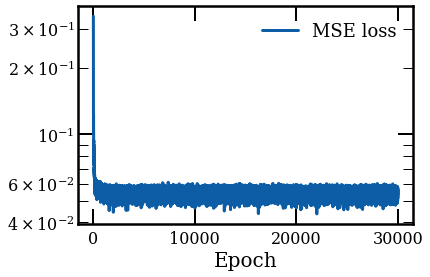

In [15]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



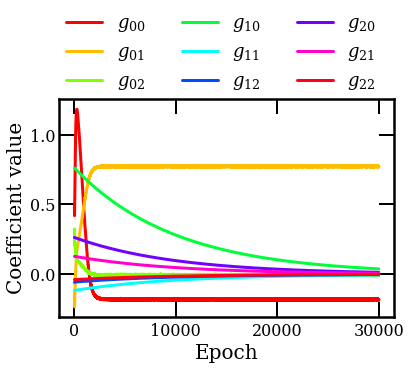

In [16]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



In [17]:



if save_dict["configs"]["use_logbins"]:
    t_bins = torch.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
    )
    t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])
   

if not run_toy:  # only needs to be done once
    data_dict,t_bins,t_bin_centers = read_in_data(distribution, order_to_match, device)
t_min = torch.min(t_bins)
t_max = torch.max(t_bins)
        



tt = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200, device=device)


colors = ["red", "purple", "blue", "green"]


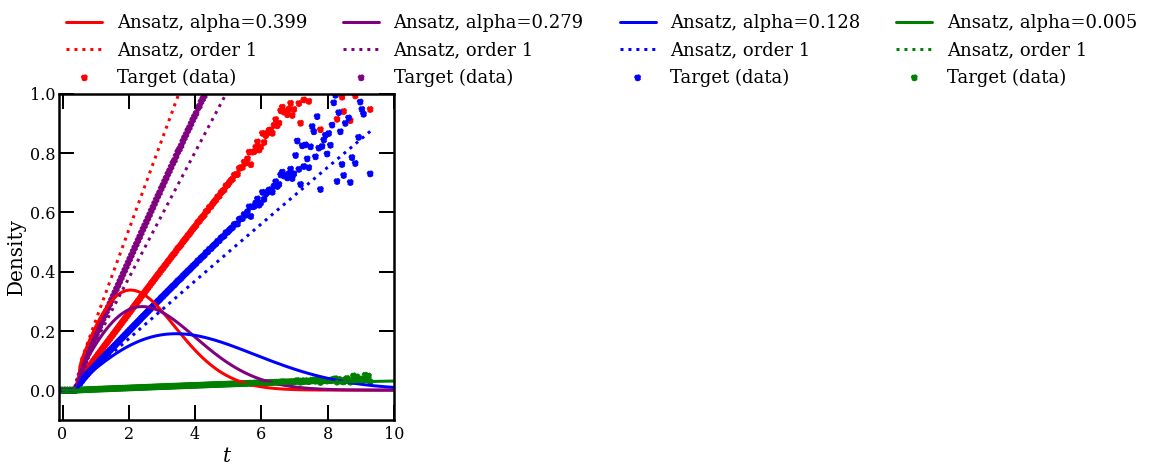

In [18]:

plt.figure(figsize = (6,6))
for i, alpha in enumerate([0.399, 0.279, 0.128, 0.005]):
    alpha_tensor = torch.tensor(alpha, device=device)

    # plot ansatz
    plt.plot(tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), 
                                         torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy(),
             label=f"Ansatz, alpha={alpha}",color=colors[i],)


      # plot ansatz derivative
    alpha_zero = torch.tensor(1e-12, device=device, requires_grad=True)
    fn = lambda a: q(
        t_bin_centers, a,  torch.tensor(g_coeffs_log[-1], device=device),  torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info
    )
    batch_ansatz = get_taylor_expanded_ansatz(fn, alpha_zero, alpha_tensor, order_to_match)



    plt.plot(t_bin_centers.detach().cpu().numpy(),batch_ansatz.detach().cpu().numpy(),label=f"Ansatz, order {order_to_match}",color=colors[i],linestyle="dotted")



    
    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict[alpha]
        #plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)
        plt.scatter(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)


plt.legend(loc = (0, 1), ncol = 4)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.1, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

## Plot Taylor expansion

In [19]:
"""
plt.figure(figsize=(12,8))


#g_coeffs_log[-1][:,2] = 0
#print(g_coeffs_log[-1])

for i, alpha in enumerate([0.148, 0.101, 0.049]):
    alpha_tensor = torch.tensor(alpha, device=device)

  
    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict[alpha]
        plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)

plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()
"""

'\nplt.figure(figsize=(12,8))\n\n\n#g_coeffs_log[-1][:,2] = 0\n#print(g_coeffs_log[-1])\n\nfor i, alpha in enumerate([0.148, 0.101, 0.049]):\n    alpha_tensor = torch.tensor(alpha, device=device)\n\n  \n    if run_toy:\n        # plot all-orders solution\n        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)\n        # plot-fixed order target\n        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)\n\n    else:\n        # plot histogram\n        loc_data, loc_err = data_dict[alpha]\n        plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target